In [2]:
import numpy as np
import skimage.io as io

In [217]:
def img_preprocess(image):
    height = image.shape[0] // 3
    cut_borders = lambda size: slice(size // 20, size // 20 * 19)
    return [
        img[cut_borders(img.shape[0]), cut_borders(img.shape[1])] 
        for img in (image[:height], image[height: 2 * height], image[2 * height: 3 * height])
    ]

In [12]:
def mse(image_1, image_2):
    return np.sum((image_1 - image_2) ** 2) / np.prod(image_1.shape)

In [13]:
def cross_cor(image_1, image_2):
    return np.sum(image_1 * image_2) / np.sqrt(np.sum(image_1 ** 2) * np.sum(image_2 ** 2))

In [288]:
def shift_images(image_1, image_2, shift):
    
    slices = np.array([
        [slice(None), slice(None)],
        [slice(None), slice(None)]
    ])
    
    for i in range(2):
        if shift[i] > 0:
            slices[0, i] = slice(-shift[i])
            slices[1, i] = slice(shift[i], None)
        elif shift[i] < 0:
            slices[0, i] = slice(-shift[i], None)
            slices[1, i] = slice(shift[i])
    
    return image_1[slices[0, 0], slices[0, 1]], image_2[slices[1, 0], slices[1, 1]]

In [285]:
def shift_images(image_1, image_2, shift):
    if shift[0] > 0:
        image_1, image_2 = image_1[:-shift[0]], image_2[shift[0]:]
    elif shift[0] < 0:
        image_1, image_2 = image_1[-shift[0]:], image_2[:shift[0]]
    
    if shift[1] > 0:
        image_1, image_2 = image_1[:, :-shift[1]], image_2[:, shift[1]:]
    elif shift[1] < 0:
        image_1, image_2 = image_1[:, -shift[1]:], image_2[:, :shift[1]]
    return image_1, image_2

In [55]:
from tqdm import tqdm_notebook as tqdm

In [156]:
from itertools import product

def find_best_shift(image_1, image_2, metrics=None, max_shift=15, start_shift=None):
    
    if start_shift is None:
        start_shift = (0, 0)
    if metrics is None:
        metrics = mse
    
    best_shift = (0, 0)
    best_metrics=np.inf
    y_range, x_range = [range(-max_shift + start, max_shift + 1 + start) for start in start_shift]
    
    for shift in product(y_range, x_range):
        shifted_1, shifted_2 = shift_images(image_1, image_2, shift)
        current_metrics = metrics(shifted_1, shifted_2)
        if current_metrics < best_metrics:
                best_shift = shift
                best_metrics = current_metrics
    
    return best_shift

In [279]:
from skimage.transform import rescale

def pyramid_recursive(images, max_size, **kwargs):
    if max(images[0].shape) > max_size:
        compresed_images = [rescale(img, 0.5) for img in images]
        approximate_shifts = 2 * pyramid_recursive(compresed_images, max_size, **kwargs)
        return np.array([
            find_best_shift(
                images[0], 
                images[1], 
                metrics=kwargs.get('metrics'), 
                max_shift=2, 
                start_shift=approximate_shifts[0]
            ),
            find_best_shift(
                images[2], 
                images[1], 
                metrics=kwargs.get('metrics'), 
                max_shift=2, 
                start_shift=approximate_shifts[1]
            ),
        ])        
    else:
        return np.array([
            find_best_shift(
                images[0], 
                images[1], 
                **kwargs
            ),
            find_best_shift(
                images[2], 
                images[1], 
                **kwargs
            ),
        ]) 

def join_images(images, shift_0, shift_2):

    top = max(0, shift_0[0], shift_2[0])
    bot = images[0].shape[0] + min(0, shift_0[0], shift_2[0])
    left = max(0, shift_0[1], shift_2[1])
    right = images[0].shape[1] + min(0, shift_0[1], shift_2[1])
    
    return np.array([
        images[2][top - shift_2[0] : bot - shift_2[0], left - shift_2[1]: right - shift_2[1]],
        images[1][top: bot, left: right],
        images[0][top - shift_0[0] : bot - shift_0[0], left - shift_0[1]: right - shift_0[1]],
    ]).transpose(1, 2, 0)
    
def align(image, g_coord, max_size=500, **kwargs):
    
    images = img_preprocess(image)
    shifts = pyramid_recursive(images, max_size)
    colored_img = join_images(images, shifts[0], shifts[1])
    b_coord = g_coord - shifts[0] - (image.shape[0] // 3, 0)
    r_coord = g_coord - shifts[1] + (image.shape[0] // 3, 0)
    return colored_img, r_coord, b_coord

In [261]:
colored_img, b_coord, r_coord = align(img, (0, 0), metrics=cross_cor)

/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [244]:
image = io.imread('data/00_input/img.png')

In [289]:
align(image, (508, 237))

(array([[[ 65, 149, 157],
         [ 94, 165, 218],
         [105, 165, 221],
         ...,
         [132, 127, 152],
         [141, 135, 158],
         [115, 139, 159]],
 
        [[ 70, 140, 130],
         [ 98, 170, 219],
         [100, 169, 223],
         ...,
         [130, 126, 154],
         [144, 135, 162],
         [112, 117, 156]],
 
        [[ 91, 140, 129],
         [123, 169, 219],
         [119, 168, 224],
         ...,
         [128, 129, 163],
         [133, 139, 166],
         [115, 114, 161]],
 
        ...,
 
        [[ 42,  40,  26],
         [ 82, 139, 138],
         [123, 139, 127],
         ...,
         [142, 186, 206],
         [136, 187, 208],
         [135, 190, 211]],
 
        [[ 40,  38,  23],
         [ 84, 131, 150],
         [108, 135, 113],
         ...,
         [126, 122, 179],
         [120, 118, 177],
         [121, 125, 188]],
 
        [[ 38,  34,  23],
         [ 71, 107, 110],
         [103, 110, 105],
         ...,
         [135, 123, 188],
  

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

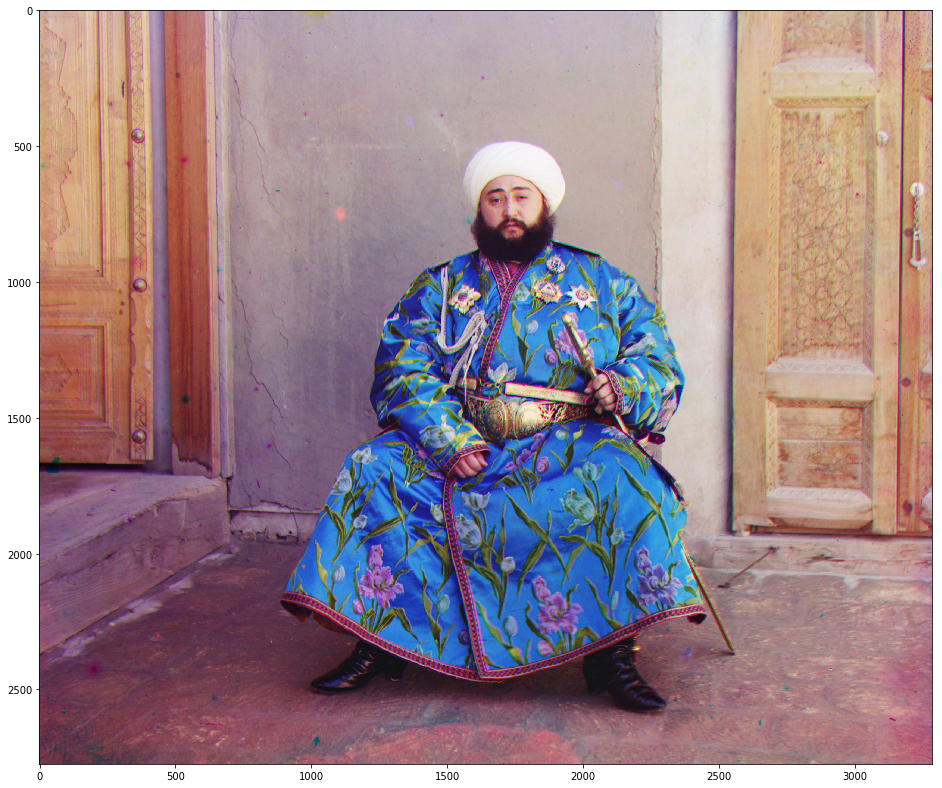

In [262]:
plt.figure(figsize=(16, 16))
plt.imshow(colored_img)

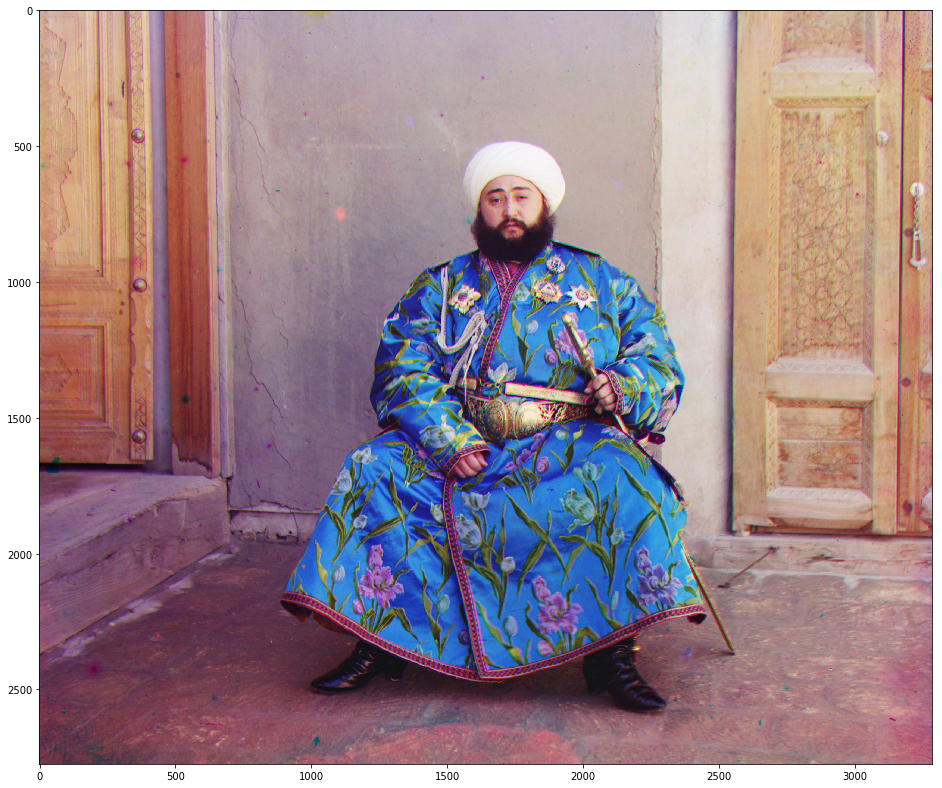

In [263]:
plt.figure(figsize=(16, 16))
plt.imshow(colored_img)

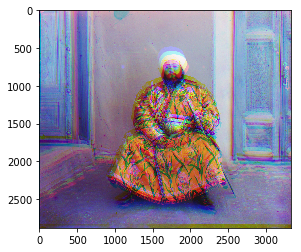

In [147]:
plt.imshow(np.array(img_preprocess(img)).transpose(1, 2, 0))

In [180]:
'{:02d}'.format(12)

'12'

In [195]:
'a\n\n '.strip()

'a'

In [266]:
import pandas as pd

for i in range(20):
    img = io.imread('data/{:02d}_input/img.png'.format(i))
    print('shape', img.shape)
    print('height', img.shape[0] // 3)
    with open('data/{:02d}_gt/gt.csv'.format(i)) as f:
        gt = np.array([int(x) for x in f.read().strip().split(',')[1:]])[[0, 1, 4, 5]]
    with open('data/{:02d}_input/g_coord.csv'.format(i)) as f:
        input = np.array([int(x) for x in f.read().strip().split(',')])
    with open('data/{:02d}_output/output.csv'.format(i)) as f:
        output = np.array([int(x) for x in f.read().strip().split(',')])
    print('input', input)
    print('gt', gt)
    print('output', output)
    print('diff', gt - output)
    print('---------------')

shape (1075, 419)
height 358
input [508 237]
gt [153 236 858 238]
output [153 236 857 238]
diff [0 0 1 0]
---------------
shape (1024, 398)
height 341
input [386 134]
gt [ 47 135 719 133]
output [ 48 134 719 133]
diff [-1  1  0  0]
---------------
shape (1074, 409)
height 358
input [443 247]
gt [ 90 250 794 246]
output [ 90 249 794 246]
diff [0 1 0 0]
---------------
shape (1166, 449)
height 388
input [623 149]
gt [ 240  149 1006  146]
output [ 240  150 1006  146]
diff [ 0 -1  0  0]
---------------
shape (1153, 445)
height 384
input [490 235]
gt [103 236 871 234]
output [104 236 871 234]
diff [-1  0  0  0]
---------------
shape (1159, 449)
height 386
input [494 238]
gt [110 241 875 236]
output [111 240 875 236]
diff [-1  1  0  0]
---------------
shape (1165, 452)
height 388
input [558 232]
gt [175 235 939 229]
output [175 235 939 229]
diff [0 0 0 0]
---------------
shape (1064, 412)
height 354
input [481 148]
gt [134 148 827 149]
output [134 148 827 149]
diff [0 0 0 0]
---------------


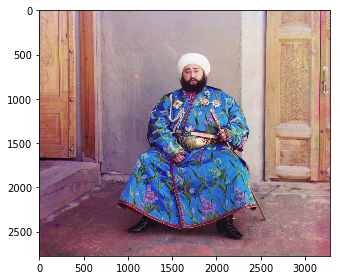

In [193]:
io.imshow(colored_img)

In [220]:
img = io.imread('data/19_input/img.png')

In [133]:
img.shape

(1075, 419)

In [267]:
from time import time

In [272]:
m1 = np.random.rand(10000, 10000)

In [275]:
m2 = m1[3:-3, 3:-3]

In [276]:
m2.sum()

49940960.14351538

In [277]:
del m2